<a href="https://www.kaggle.com/code/ibrahimnibrahim/gender-classification-by-eye-morph-f1-0-977?scriptVersionId=244215399" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf

train_ds,test_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/eyes-rtte',
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(60, 60),
    batch_size=32,
    label_mode="binary"
)
class_names=train_ds.class_names

2025-06-07 11:40:50.259680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749296450.438917      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749296450.488731      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 11525 files belonging to 2 classes.
Using 9220 files for training.
Using 2305 files for validation.


I0000 00:00:1749296477.098758      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [2]:
train_dataset=train_ds.prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(buffer_size=1000)
test_a_dataset=test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [3]:
from tensorflow.keras.applications import EfficientNetB3

base_model = EfficientNetB3(
    weights='imagenet',  
    input_shape=(300, 300, 3),
    include_top=False    
)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.2)
], name="data_augmentation")


inputs = tf.keras.layers.Input(shape=(60, 60, 3))
x = data_augmentation(inputs)        
x = tf.keras.layers.UpSampling2D(size=(5, 5), interpolation='bilinear', name="upsampling_layer")(x)
x = base_model(x, training=False)        
x = tf.keras.layers.GlobalAveragePooling2D()(x)    
x = tf.keras.layers.Dense(512, activation='relu')(x)  
x = tf.keras.layers.Dense(1, activation='sigmoid')(x) 

final_model = tf.keras.models.Model(inputs=inputs, outputs=x)

final_model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 60, 60, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 60, 60, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsampling_layer (UpSampling2D)      │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 10, 10, 1536)        │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,570,992 (44.14 MB)

 Trainable params: 11,483,689 (43.81 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [4]:
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),  
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [5]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,  
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=3, 
    min_lr=1e-7
)


class StopOnValAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target=0.985):
        super().__init__()
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None and val_acc >= self.target:
            print(f"\nReached {val_acc:.2%} val_accuracy — stopping training.")
            self.model.stop_training = True

In [6]:
history = final_model.fit(
    train_dataset,
    validation_data=test_a_dataset,
    epochs=100,
    callbacks=[early_stopping, reduce_lr,StopOnValAccuracy(target=0.980)]
)

Epoch 1/100


E0000 00:00:1749296575.956192      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1749296595.341039      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


289/289 ━━━━━━━━━━━━━━━━━━━━ 362s 865ms/step - accuracy: 0.8427 - loss: 0.3690 - val_accuracy: 0.9302 - val_loss: 0.1778 - learning_rate: 0.0010
Epoch 2/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 244s 831ms/step - accuracy: 0.9357 - loss: 0.1734 - val_accuracy: 0.9362 - val_loss: 0.1600 - learning_rate: 0.0010
Epoch 3/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 244s 832ms/step - accuracy: 0.9421 - loss: 0.1534 - val_accuracy: 0.9549 - val_loss: 0.1198 - learning_rate: 0.0010
Epoch 4/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 244s 832ms/step - accuracy: 0.9526 - loss: 0.1243 - val_accuracy: 0.9492 - val_loss: 0.1279 - learning_rate: 0.0010
Epoch 5/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 244s 832ms/step - accuracy: 0.9577 - loss: 0.1173 - val_accuracy: 0.9223 - val_loss: 0.2099 - learning_rate: 0.0010
Epoch 6/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 243s 830ms/step - accuracy: 0.9531 - loss: 0.1243 - val_accuracy: 0.9566 - val_loss: 0.1204 - learning_rate: 0.0010
Epoch 7/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 243s 831ms/step - accuracy: 0

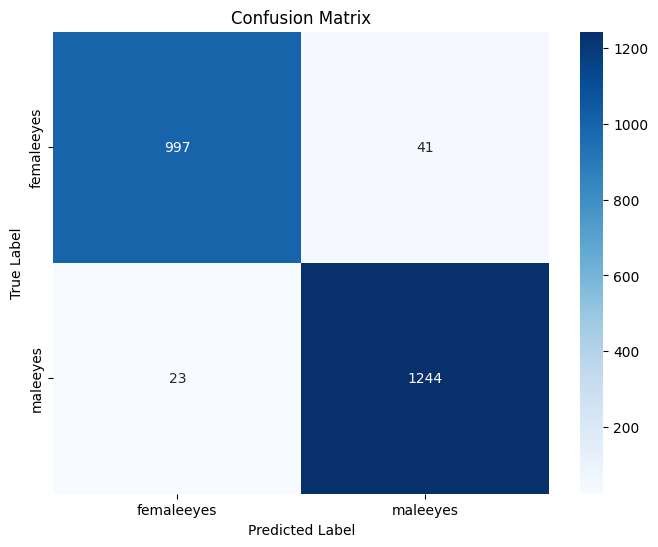

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions from the model on the test dataset
y_true = []
y_pred = []

for images, labels in test_a_dataset:
    predictions = final_model.predict(images,verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(predictions.flatten())

# Convert predictions to binary (0 or 1) based on a threshold (e.g., 0.5)
y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [8]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred_binary, target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

  femaleeyes       0.98      0.96      0.97      1038
    maleeyes       0.97      0.98      0.97      1267

    accuracy                           0.97      2305
   macro avg       0.97      0.97      0.97      2305
weighted avg       0.97      0.97      0.97      2305

